# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
#Install the emoji package if not already installed
#!pip install emoji
#!pip install textacy

In [2]:
import os
import regex as re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [3]:
# Add any additional import statements you need here
import html
from textacy import preprocessing
import string
import nltk

stop_words = set(stopwords.words("english"))


In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/travis/mod2/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [5]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = 0
    for i in tokens:
        num_characters += len(i)
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [6]:
text = "here is some example text with other example text here in this text".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.


Q: Why is it beneficial to use assertion statements in your code? 

A: The benifeit to using assert in the function is that is ensures that the code is functioning within given parameters and desired outcomes and if they are not met, it will throw an assertion error with custom verbiage which is great for debugging.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [7]:
# Read in the lyrics data
lyric_directory = str(data_location + lyrics_folder)
lyric_df = pd.DataFrame()

with os.scandir(lyric_directory) as artist:
    for artist in artist:
        if not artist.name.startswith('.') and artist.is_dir():
            with os.scandir(artist.path) as songs:
                    for song in songs:
                        if not song.name.startswith('.'):
                            with open(song.path) as f:
                                lines = f.read()
                            lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)



In [8]:
lyric_df.sample(10)


,Artist,song,content
263,cher,cher_dowhatyougottado.txt,"""Do What You Gotta Do""\n\n\n\nGirl I can under..."
79,robyn,robyn_88days.txt,"""88 Days""\n\n\n\nI light a candle in the morni..."
132,cher,cher_ayounggirluneenfante.txt,"""A Young Girl (Une Enfante)""\n\n\n\nShe left h..."
25,robyn,robyn_shouldhaveknown106828.txt,"""Should Have Known""\n\n\n\nI should have seen ..."
342,cher,cher_igotosleep.txt,"""I Go To Sleep""\n\n\n\nWhen I look up from my ..."
277,cher,cher_clicksong.txt,"""Click Song""\n\n\n\nIgqira lendlela nguqo ngqo..."
2,robyn,robyn_beach2k20.txt,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
371,cher,cher_whentheloveisgone.txt,"""When The Love Is Gone""\n\n\n\nWhen the love i..."
178,cher,cher_alfie.txt,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."
145,cher,cher_bangbang.txt,"""Bang-Bang""\n\n\n\nBang bang you shot me down\..."


In [9]:
# Read in the twitter data
twitter_directory = str(data_location + twitter_folder)
twitter_df = pd.DataFrame()

cher_followers_df = pd.read_csv(twitter_directory + 'cher_followers.txt', sep='\t')
cher_followers_data_df = pd.read_csv(twitter_directory + 'cher_followers_data.txt', sep='\t',header=0, error_bad_lines=False);

cher_followers_data_df = cher_followers_data_df.sample(75000)

robyn_followers_df = pd.read_csv(twitter_directory + 'robynkonichiwa_followers.txt', sep='\t')
robyn_followers_data_df = pd.read_csv(twitter_directory + 'robynkonichiwa_followers_data.txt', sep='\t',header=0, error_bad_lines=False);
robyn_followers_data_df = robyn_followers_data_df.sample(75000)



b'Skipping line 624: expected 7 fields, saw 12\nSkipping line 17506: expected 7 fields, saw 12\nSkipping line 104621: expected 7 fields, saw 12\n'
b'Skipping line 188924: expected 7 fields, saw 12\n'
b'Skipping line 301600: expected 7 fields, saw 12\n'
b'Skipping line 429936: expected 7 fields, saw 12\nSkipping line 444405: expected 7 fields, saw 12\n'
b'Skipping line 677792: expected 7 fields, saw 12\nSkipping line 773482: expected 7 fields, saw 12\n'
b'Skipping line 818258: expected 7 fields, saw 12\nSkipping line 895225: expected 7 fields, saw 12\n'
b'Skipping line 955213: expected 7 fields, saw 10\nSkipping line 994827: expected 7 fields, saw 12\n'
b'Skipping line 1246039: expected 7 fields, saw 12\n'
b'Skipping line 1569117: expected 7 fields, saw 12\n'
b'Skipping line 2127250: expected 7 fields, saw 12\n'
b'Skipping line 2335031: expected 7 fields, saw 12\n'
b'Skipping line 2681065: expected 7 fields, saw 10\n'
b'Skipping line 3147696: expected 7 fields, saw 12\n'


In [10]:
robyn_followers_data_df.shape

(75000, 7)

In [11]:
cher_followers_data_df['description'] = cher_followers_data_df['description'].astype('string')
cher_followers_data_df['description'] = cher_followers_data_df['description'].fillna('')

robyn_followers_data_df['description'] = robyn_followers_data_df['description'].astype('string')
robyn_followers_data_df['description'] = robyn_followers_data_df['description'].fillna('')

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [12]:
punctuation = set(punctuation) # speeds up comparison

In [13]:
# create your clean twitter data here

## This calculates the impurity in an instance of tokens, used to find characters worth removing
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')
def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len:
        return 0 
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)
    print(impurity(text))

## Function to clean the text by removing matches on the regex rules
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text) # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'##',' ',text)
    text = re.sub(r'{{_}}',' ',text)
    text = re.sub(r'/\/',' ',text)
    text = re.sub(r'//\\',' ',text)
    text = re.sub(r'\\',' ',text)
    #Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    return text.strip()

def normalize(text):
    text = preprocessing.normalize.hyphenated_words(text)
    text = preprocessing.normalize.quotation_marks(text)
    text = preprocessing.normalize.unicode(text)
    text = preprocessing.remove.accents(text)
    return text


def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stop_words]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline): 
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [14]:
cher_followers_data_df['clean_text'] = cher_followers_data_df['description'].map(clean)
cher_followers_data_df['clean_text'] = cher_followers_data_df['clean_text'].astype('string')
cher_followers_data_df['clean_text'] = cher_followers_data_df['clean_text'].map(normalize)
cher_followers_data_df['tokens'] = cher_followers_data_df['clean_text'].apply(prepare, pipeline=pipeline)
cher_followers_data_df.head()

,screen_name,name,id,location,followers_count,friends_count,description,clean_text,tokens
2063875,doctormaori101,Doctormaori101,3.045958e+09,NaN,25.0,454.0,,,[]
2133291,ganeshbaral11,Ganesh prasad Baral,2.953919e+09,"Kathamandu,Nepal",10.0,148.0,CA Student at Institute of Chartered Accountan...,CA Student at Institute of Chartered Accountan...,"[ca, student, institute, chartered, accountant..."
1216491,VerrecktKelly,Kelly Verreckt,9.156692e+17,"Tessenderlo, België",2.0,123.0,,,[]
2668535,RyanAnthony_J,Ryan Jones,4.489908e+08,England,69.0,212.0,running on the road to fortune!,running on the road to fortune,"[running, road, fortune]"
2316372,phashainah,inah phasha,2.715367e+09,NaN,0.0,26.0,,,[]


In [15]:
robyn_followers_data_df['clean_text'] = robyn_followers_data_df['description'].map(clean)
robyn_followers_data_df['clean_text'] = robyn_followers_data_df['clean_text'].astype('string')
robyn_followers_data_df['clean_text'] = robyn_followers_data_df['clean_text'].map(normalize)
robyn_followers_data_df['tokens'] = robyn_followers_data_df['clean_text'].apply(prepare, pipeline=pipeline)
robyn_followers_data_df.head()

,screen_name,name,id,location,followers_count,friends_count,description,clean_text,tokens
254169,KessariXO,KESSARI,515856434,Los Angeles,27,228,I'm a model and a singer. Follow me on Faceboo...,I m a model and a singer Follow me on Faceboo...,"[model, singer, follow, facebook, http, co, lv..."
342790,bigmue,Wolfgang Müller,9576622,"iPhone: 48.158478,11.649231",1051,1804,"don´t follow me, i´m lost too",don t follow me i m lost too,"[follow, lost]"
221037,zarahthegr8,Sarah Williams,727702934,"Klippan, Skåne, Sweden",20,134,Mom of 2 amazing kids Theodor and Enya. Canadi...,Mom of 2 amazing kids Theodor and Enya Canadi...,"[mom, amazing, kids, theodor, enya, canadian, ..."
66396,Kiro95383134,Kiro,4892313323,NaN,3,33,,,[]
343792,CaleyZ,Caley Zingerle,55871228,NaN,0,20,,,[]


In [16]:
# create your clean lyrics data here
lyric_df['clean_text'] = lyric_df['content'].map(clean)
lyric_df['clean_text'] = lyric_df['clean_text'].map(normalize)
lyric_df['tokens'] = lyric_df['clean_text'].apply(prepare, pipeline=pipeline)

In [17]:
lyric_df.head()
robyn_lyric_df = pd.DataFrame(lyric_df[lyric_df['Artist'] == 'robyn'])
cher_lyric_df = pd.DataFrame(lyric_df[lyric_df['Artist'] == 'cher'])


In [18]:
robyn_lyric_df.head()

,Artist,song,content,clean_text,tokens
0,robyn,robyn_includemeout.txt,"""Include Me Out""\n\n\n\nIt is really very simp...",Include Me Out It is really very simple Just ...,"[include, really, simple, single, pulse, repea..."
1,robyn,robyn_electric.txt,"""Electric""\n\n\n\nElectric...\n\nIt's electric...",Electric Electric It s electric It s a nat...,"[electric, electric, electric, natural, high, ..."
2,robyn,robyn_beach2k20.txt,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow...",Beach 2K20 So you wanna go out How you gonn...,"[beach, 2k20, wanna, go, gonna, get, ok, call,..."
3,robyn,robyn_lovekills.txt,"""Love Kills""\n\n\n\nIf you're looking for love...",Love Kills If you re looking for love Get a h...,"[love, kills, looking, love, get, heart, made,..."
4,robyn,robyn_timemachine.txt,"""Time Machine""\n\n\n\nHey, what did I do?\nCan...",Time Machine Hey what did I do Can t believ...,"[time, machine, hey, believe, fit, threw, stup..."


## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [19]:
# artist_descriptions = dict()
# for artist in your_artists:
#     artist_descriptions[artist] = []
#     for description in df[df["artist"] == artist]["description"]:
#        artist_descriptions[artist].extend(description.split())

In [20]:
cher_lyrics = []
for description in cher_lyric_df["clean_text"]:
    cher_lyrics.extend(description.split())

cher_followers = []
for description in cher_followers_data_df["clean_text"]:
    cher_followers.extend(description.split())
    
robyn_lyrics = []
for description in robyn_lyric_df["clean_text"]:
    robyn_lyrics.extend(description.split())
    
robyn_followers = []
for description in robyn_followers_data_df["clean_text"]:
    robyn_followers.extend(description.split())

In [21]:
print('Cher Lyrics Descriptive Statistics')
print(descriptive_stats(cher_lyrics))
print(cher_lyric_df["tokens"].describe(include='O').T)
print('\n')
print('Cher Followers Descriptive Statistics')
print(descriptive_stats(cher_followers))
print(cher_followers_data_df["tokens"].describe(include='O').T)
print('\n')
print('Robyn Lyrics Descriptive Statistics')
print(descriptive_stats(robyn_lyrics))
print(robyn_lyric_df["tokens"].describe(include='O').T)
print('\n')
print('Robyn Followers Descriptive Statistics')
print(descriptive_stats(robyn_followers))
print(robyn_followers_data_df["tokens"].describe(include='O').T)


Cher Lyrics Descriptive Statistics
There are 73966 tokens in the data.
There are 4579 unique tokens in the data.
There are 264181 characters in the data.
The lexical diversity is 0.062 in the data.
[73966, 4579, 0.06190682205337587, 264181]
count                                                   316
unique                                                  316
top       [hate, sleep, alone, thing, could, good, love,...
freq                                                      1
Name: tokens, dtype: object


Cher Followers Descriptive Statistics
There are 447550 tokens in the data.
There are 70386 unique tokens in the data.
There are 2094326 characters in the data.
The lexical diversity is 0.157 in the data.
[447550, 70386, 0.15726957881800915, 2094326]
count     75000
unique    35048
top          []
freq      38640
Name: tokens, dtype: object


Robyn Lyrics Descriptive Statistics
There are 31177 tokens in the data.
There are 2642 unique tokens in the data.
There are 111836 characters in 

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: The top words most likely would wind up being stop words which would provide little usable information

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I believed the lexical value to be much higher than they were. However when considering the genre of music that the two artists are part of, the genre typically has similar themes and similar structures which consists of a significant amount of chorus and repetitive sections of a song.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [27]:
def is_emoji(s):
    return(emoji.is_emoji(s))

assert(is_emoji("❤️"))
assert(not is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [28]:
cher_followers_desc = []
for description in cher_followers_data_df["description"]:
    cher_followers_desc.extend(description.split())

In [29]:
# Your code here
emoji_tokens = []
for token in cher_followers_desc:
    if is_emoji(token) == True:
        emoji_tokens.append(token)
counter = Counter(emoji_tokens)
most_common = counter.most_common(10)
print(most_common)

[('❤️', 266), ('🏳️\u200d🌈', 258), ('❤', 199), ('♥', 185), ('✨', 152), ('🌈', 98), ('💙', 71), ('💕', 59), ('💜', 56), ('🇺🇸', 54)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [30]:

# Your code here
hash_tokens = []
for token in cher_followers_desc:
    if re.match('(?:#)([A-Za-z0-9_](?:(?:[A-Za-z0-9_]|(?:\.(?!\.))){0,28}(?:[A-Za-z0-9_]))?)', token):
        hash_tokens.append(token)
counter = Counter(hash_tokens) 
most_common = counter.most_common(10)

print(most_common)

[('#BLM', 154), ('#Resist', 112), ('#BlackLivesMatter', 89), ('#FBR', 62), ('#resist', 53), ('#1', 48), ('#TheResistance', 47), ('#blacklivesmatter', 43), ('#Resistance', 31), ('#RESIST', 26)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [31]:
lyrics_desc = []
for title in lyric_df["content"]:
    title = title.splitlines()[0]
    lyrics_desc.append(title.split())

In [32]:
# Your code here
song_tokens = []
for token in lyrics_desc:
    song_tokens.extend(token)
counter = Counter(song_tokens) 
most_common = counter.most_common(10)

print(most_common)

[('The', 36), ('To', 34), ('You', 25), ('"The', 25), ('Of', 23), ('"I', 22), ('A', 18), ('Me"', 17), ('Love', 17), ('You"', 17)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

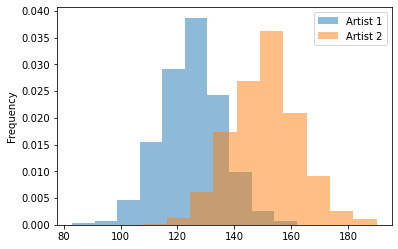

In [33]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: This matches on one to unlimited amount of whitespace characters.


In [34]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

In [35]:
# Your lyric length comparison chart here. 
len_df = lyric_df[['Artist','content']].copy()


In [36]:
song_length = []
for i in len_df['content']:
    text = tokenize_lyrics(str(i))
    #text = len(text)
    song_length.append(len(text))
len_df['song_length'] = song_length
len_df.sample(20)

,Artist,content,song_length
309,cher,"""Go Now""\n\n\n\nWe've already said...goodbye.\...",181
313,cher,"""The First Time""\n\n\n\nOh I heard a rooster c...",136
242,cher,"""Save Up All Your Tears""\n\n\n\nI can't figure...",416
304,cher,"""The Sun Ain't Gonna Shine Anymore""\n\n\n\nLon...",187
264,cher,"""Holy Smoke""\n\n\n\nWhere do we draw the line ...",306
170,cher,"""How Long Has This Been Going On""\n\n\n\nI cou...",206
19,robyn,"""O Baby""\n\n\n\n[Chorus:]\nO baby you're makin...",170
172,cher,"""SOS""\n\n\n\nWhere are those happy days, they ...",255
140,cher,"""Love Enough""\n\n\n\nSomething goes wrong,Some...",200
165,cher,"""The Long And Winding Road""\n\n\n\nThe long an...",156


Artist
cher     AxesSubplot(0.125,0.125;0.775x0.755)
robyn    AxesSubplot(0.125,0.125;0.775x0.755)
Name: song_length, dtype: object

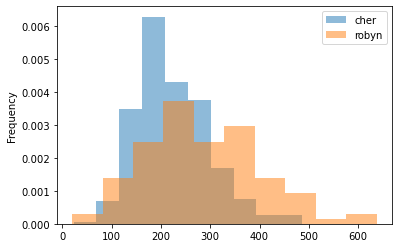

In [37]:
len_df.groupby('Artist')['song_length'].plot(kind="hist",density=True,alpha=0.5,legend=True)
